In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bloom import *
from scipy import stats
import os

### Вспомогательные функции

In [10]:
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

### Загрузка и подготовка данных

In [11]:
name = os.environ['asset']
print('Анализируем', name)

Анализируем HSI


In [12]:
vea_res = bdh(f"HSI INDEX", ["30DAY_IMPVOL_100.0%MNY_DF", "PX_LAST"], date_from = '2010-01-01')

In [13]:
df = pd.DataFrame.from_dict(vea_res)
index = pd.date_range(df['date'].values[0], df['date'].values[-1])
df.index = pd.to_datetime(df['date'])
df.drop(columns=['date'], inplace=True)
df.rename(columns={'30DAY_IMPVOL_100.0%MNY_DF':'d30IV'}, inplace=True)
df = df.reindex(index=index, method='nearest')

In [14]:
df.to_csv(f'{name}.csv')

In [15]:
dfnona = df.fillna(method='bfill')

In [16]:
dfnona_1 = pd.concat([dfnona, dfnona.shift()], axis=1)
dfnonashft = dfnona_1.drop(dfnona_1.index[0])
def f(x):
    c = x["PX_LAST"][0]
    c1 = x["PX_LAST"][1]
    return np.log(c/c1)

changes = dfnonashft.apply(f, axis=1).values

In [17]:
dfnona = dfnona.drop(dfnona.index[0])

### Посчитаем HV с n-дневним окном

In [18]:
def calc_hv(changes, n_days):
    n = n_days - 1 # между 30 днями 29 изменений цены
    ch = rolling_window(changes, n)
    dHV = np.sqrt(np.sum((ch - ch.mean(axis=1).reshape(ch.shape[0], 1)) ** 2, axis=1)/(n-1) * 365) * 100
    dHV = np.insert(dHV, 0, np.zeros(n-1))
    return dHV

In [19]:
dfnona['d30HV'] = calc_hv(changes, 30)
dfnona['d15HV'] = calc_hv(changes, 15)

### Посчитаем RV c n-дневним окном

In [20]:
def calc_rv(changes, n_days):
    n = n_days - 1 # между 30 днями 29 изменений цены
    ch = rolling_window(changes, n)
    dRV = np.sqrt(np.sum(ch ** 2, axis=1)/(n-1) * 365) * 100
    dRV = np.insert(dRV, dRV.shape[0], np.zeros(n-1))
    return dRV

In [21]:
dfnona['d30RV'] = calc_rv(changes, 30)

### Рисуем графики

In [22]:
cut = 100

dfnona = dfnona.drop(pd.date_range(dfnona.index[0], dfnona.index[cut]))
dfnona = dfnona.drop(pd.date_range(dfnona.index[-cut], dfnona.index[-1]))

<AxesSubplot:title={'center':'Сравнение IV и RV'}>

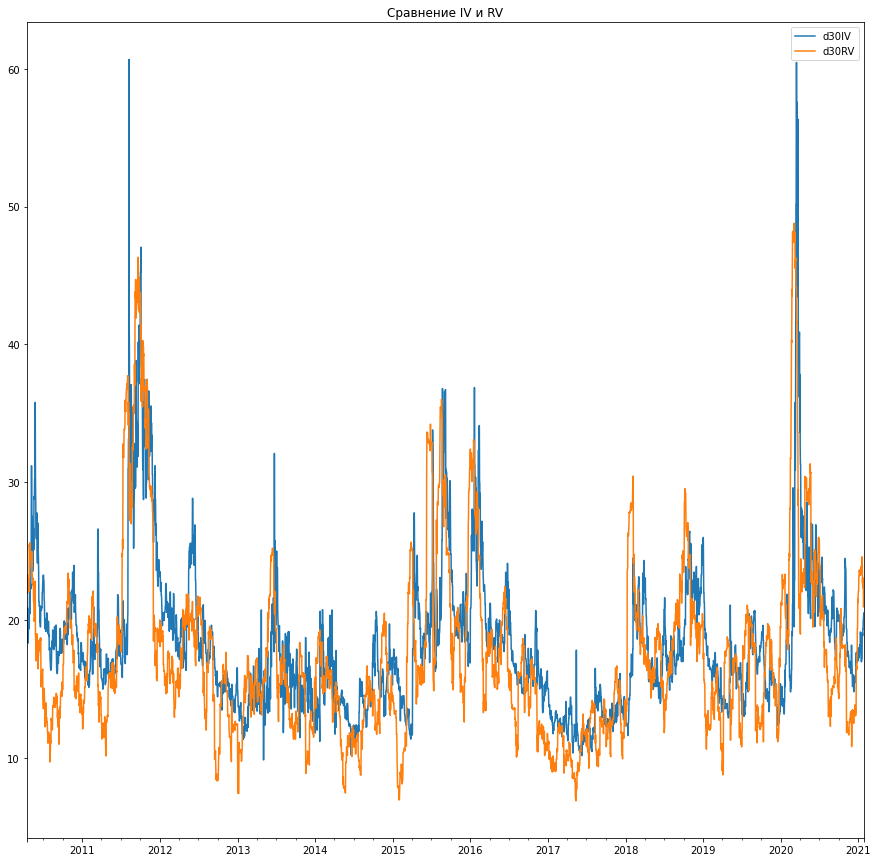

In [23]:
dfnona[['d30IV', 'd30RV']].plot(figsize=(15,15), title='Сравнение IV и RV')

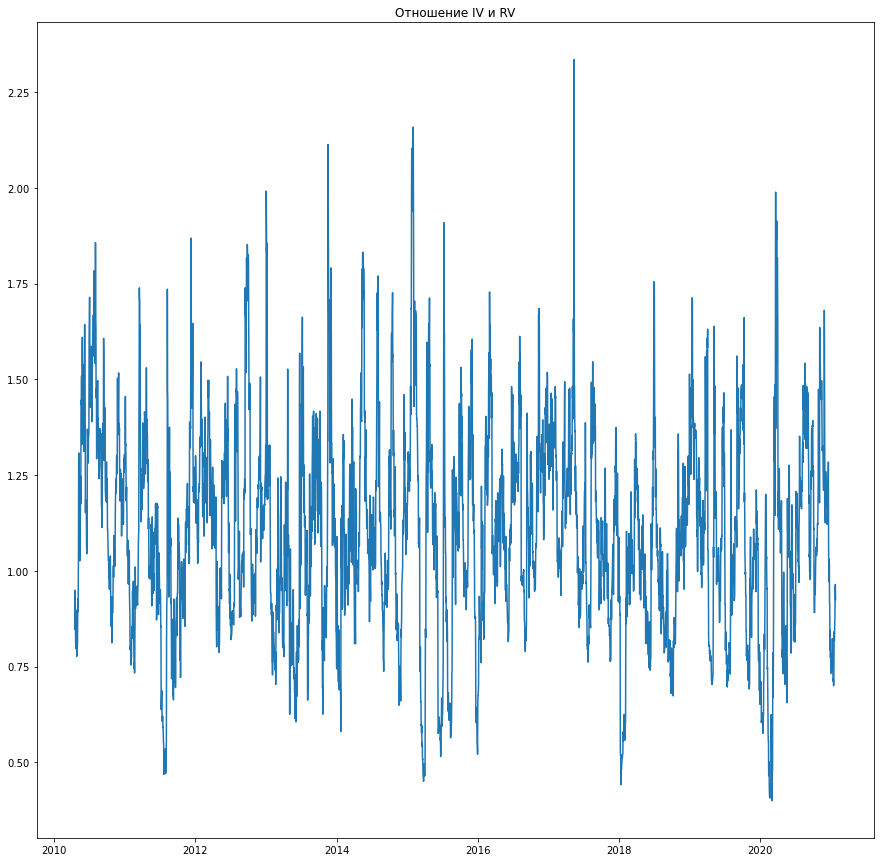

In [24]:
plt.figure(figsize=(15,15))
plt.plot(dfnona.index, dfnona['d30IV'].values / dfnona['d30RV'].values)
plt.title('Отношение IV и RV')
plt.show()

<AxesSubplot:title={'center':'Сравнение IV и HV'}>

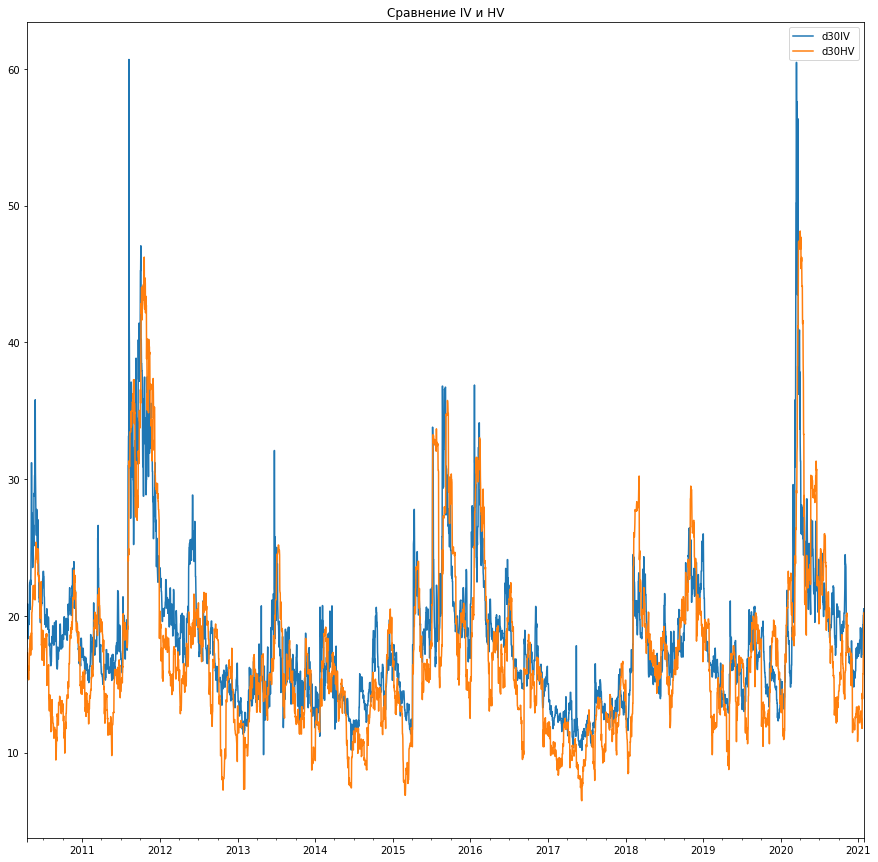

In [25]:
dfnona[['d30IV', 'd30HV']].plot(figsize=(15,15), title='Сравнение IV и HV')

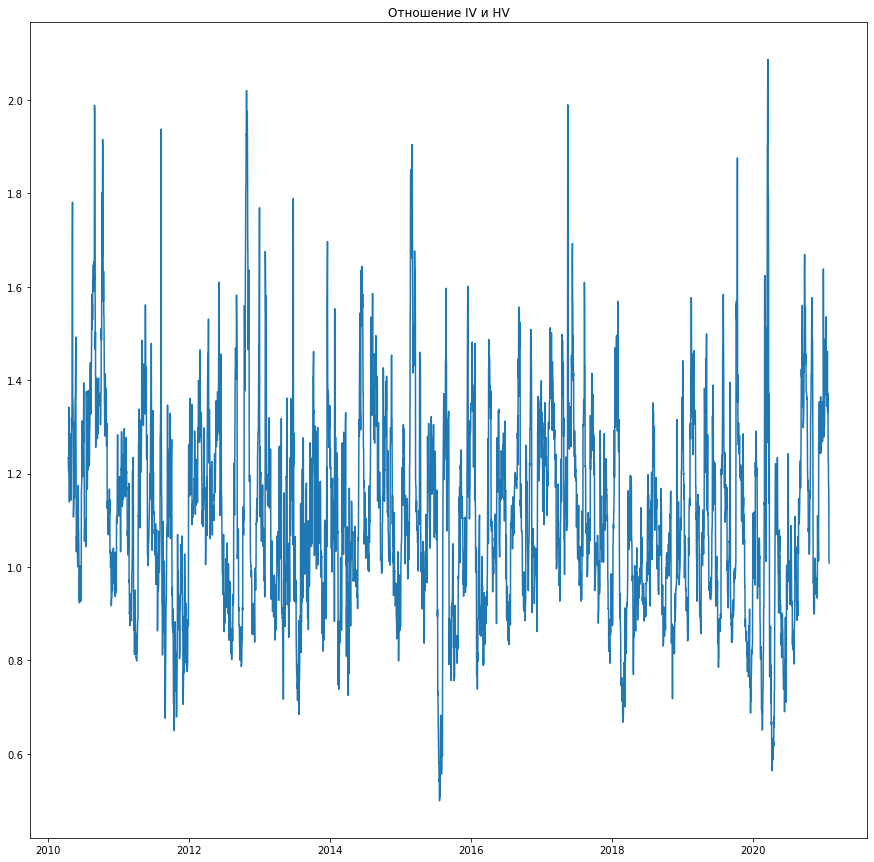

In [26]:
plt.figure(figsize=(15,15))
plt.plot(dfnona.index, dfnona['d30IV'].values / dfnona['d30HV'].values)
plt.title('Отношение IV и HV')
plt.show()

### Посмотрим корреляции

In [27]:
dfnona.drop(columns=['PX_LAST']).corr(method='pearson')

,d30IV,d30HV,d15HV,d30RV
d30IV,1.000000,0.803175,0.786752,0.663225
d30HV,0.803175,1.000000,0.866083,0.548261
d15HV,0.786752,0.866083,1.000000,0.524212
d30RV,0.663225,0.548261,0.524212,1.000000


### Построим распределение IV

In [28]:
dfdna = df.dropna()
distr = stats.lognorm(*stats.lognorm.fit(dfdna['d30IV'].values))
print('На сколько хорошо описывается логнормальным распределением?', stats.kstest(dfdna['d30IV'].values, lambda x: distr.cdf(x)), sep='\n')

На сколько хорошо описывается логнормальным распределением?
KstestResult(statistic=0.028325339182314946, pvalue=0.0025588083053534206)


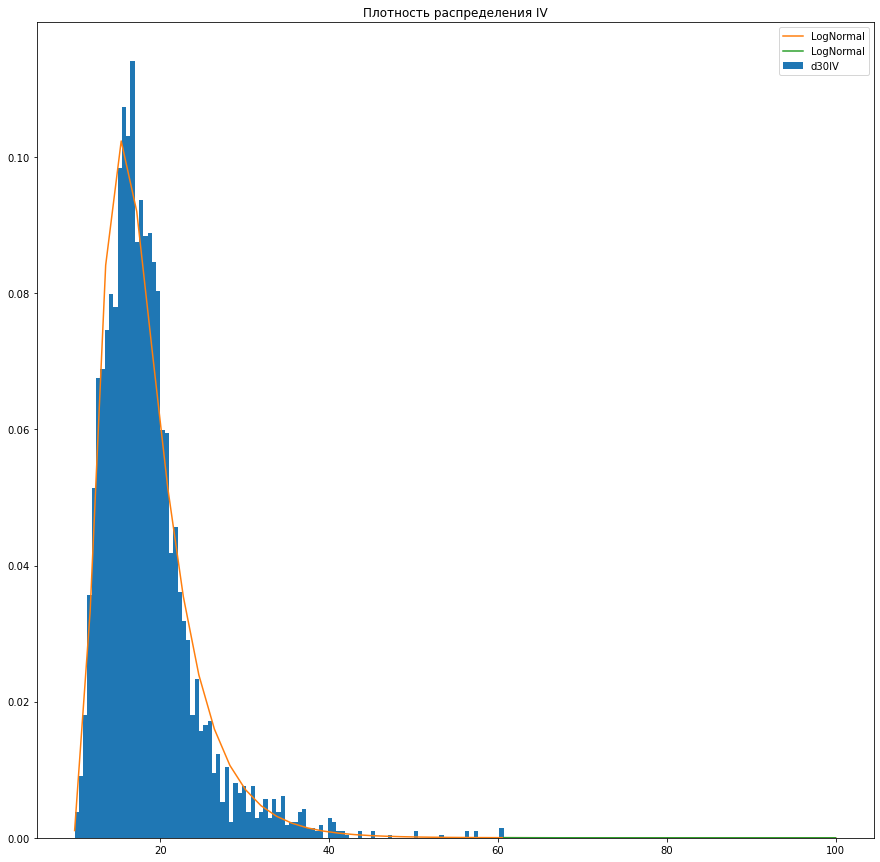

In [29]:
x = np.linspace((dfdna['d30IV'].values.min(), dfdna['d30IV'].values.max()), 100)
plt.figure(figsize=(15,15))
plt.hist(dfdna['d30IV'].values, bins=100, density=True, label='d30IV')
plt.plot(x, distr.pdf(x), label="LogNormal")
plt.title('Плотность распределения IV')
plt.legend()
plt.show()

### Построим распределение HV

In [30]:
distr = stats.lognorm(*stats.lognorm.fit(dfnona['d30RV'].values))
print('На сколько хорошо описывается логнормальным распределением?', stats.kstest(dfnona['d30RV'].values, lambda x: distr.cdf(x)), sep='\n')

На сколько хорошо описывается логнормальным распределением?
KstestResult(statistic=0.04481963722035753, pvalue=2.5749282532960343e-07)


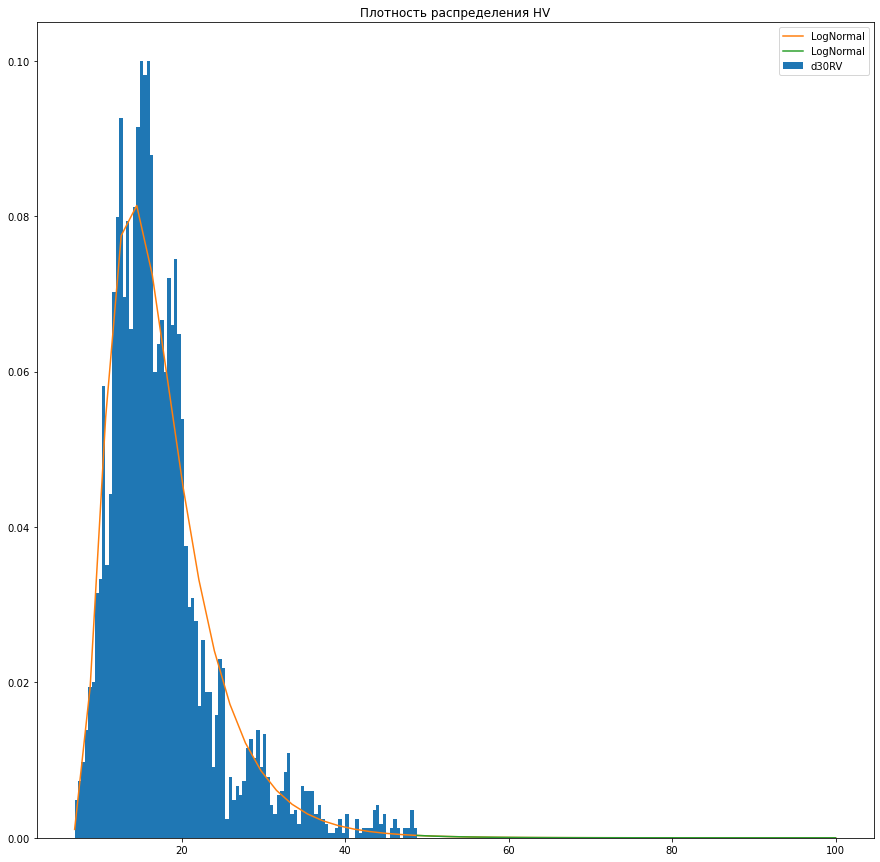

In [31]:
x = np.linspace((dfnona['d30RV'].values.min(), dfnona['d30RV'].values.max()), 100)
plt.figure(figsize=(15,15))
plt.hist(dfnona['d30RV'].values, bins=100, density=True, label='d30RV')
plt.plot(x, distr.pdf(x), label="LogNormal")
plt.title('Плотность распределения HV')
plt.legend()
plt.show()

### Рассмотрим распределение изменений IV

In [32]:
dfnona_1 = pd.concat([dfdna, dfdna.shift()], axis=1)
dfnonashft = dfnona_1.drop(dfnona_1.index[0])
def f(x):
    c = x["d30IV"][0]
    c1 = x["d30IV"][1]
    return c/c1

changes = dfnonashft.apply(f, axis=1).values
changes = np.delete(changes, np.argwhere(changes == 1))

In [33]:
distr = stats.t(*stats.t.fit(changes))
print('На сколько хорошо описывается логнормальным распределением?', stats.kstest(changes, lambda x: distr.cdf(x)), sep='\n')

На сколько хорошо описывается логнормальным распределением?
KstestResult(statistic=0.027231376480193303, pvalue=0.03114389155416286)


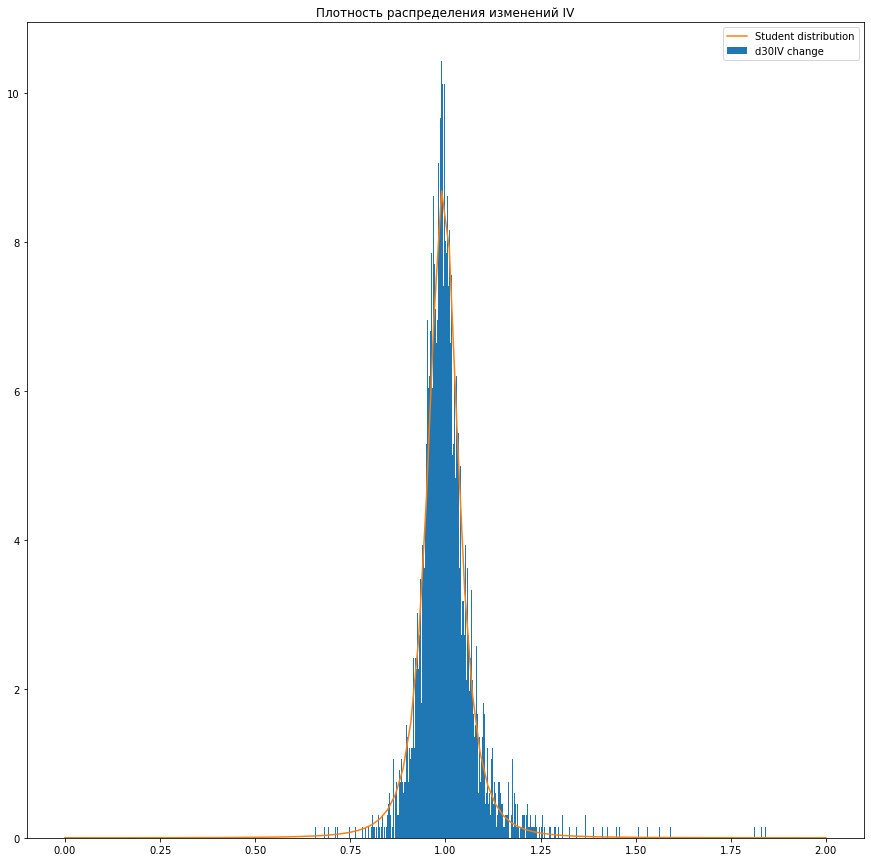

In [34]:
x = np.linspace(0, 2, 100)
plt.figure(figsize=(15,15))
plt.hist(changes, bins=500, density=True, label='d30IV change')
plt.plot(x, distr.pdf(x), label="Student distribution")
plt.title('Плотность распределения изменений IV')
plt.legend()
plt.show()

### Рассмотрим распределение изменений HV

In [35]:
dfnona_1 = pd.concat([dfnona, dfnona.shift()], axis=1)
dfnonashft = dfnona_1.drop(dfnona_1.index[0])
def f(x):
    c = x["d30HV"][0]
    c1 = x["d30HV"][1]
    return c/c1

changes = dfnonashft.apply(f, axis=1).values
changes = np.delete(changes, np.argwhere(changes == 1))

In [36]:
distr = stats.t(*stats.t.fit(changes))
print('На сколько хорошо описывается логнормальным распределением?', stats.kstest(changes, lambda x: distr.cdf(x)), sep='\n')

На сколько хорошо описывается логнормальным распределением?
KstestResult(statistic=0.05305307316104235, pvalue=8.886358291993147e-10)


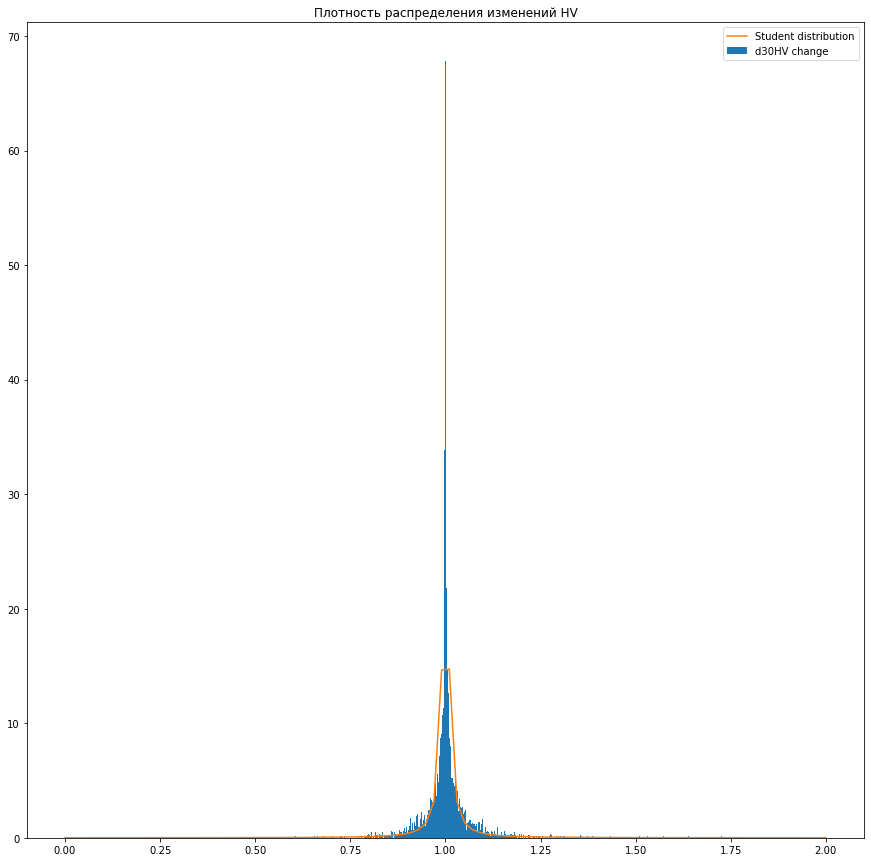

In [37]:
x = np.linspace(0, 2, 100)
plt.figure(figsize=(15,15))
plt.hist(changes, bins=500, density=True, label='d30HV change')
plt.plot(x, distr.pdf(x), label="Student distribution")
plt.title('Плотность распределения изменений HV')
plt.legend()
plt.show()